In [44]:
# from google.colab import drive
# drive.mount('/content/drive')

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import joblib


In [46]:
# # Load dataset
# d_house = pd.read_csv('/content/drive/MyDrive/Dibimbing/Assignment Day 25/boston.csv')

# # Tampilkan 5 baris pertama
# d_house.head()

In [47]:
# Load dataset
d_house = pd.read_csv('./boston.csv')

# Tampilkan 5 baris pertama
d_house.head()


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [48]:
# Mengecek nilai yang hilang
d_house.isnull().sum()


crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [49]:
# Mengganti outlier dengan nilai median menggunakan IQR (Interquartile Range)
def handle_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median_value = df[col].median()
        df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])
    return df

# Tentukan kolom yang perlu diperiksa untuk outlier
columns_to_check = ['black', 'crim', 'zn','indus']  # Misalnya, ganti dengan kolom yang sesuai
d_house = handle_outliers(d_house, columns_to_check)


In [50]:
# Terapkan log transformasi pada fitur yang tidak normal
def log_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])  # Menggunakan np.log1p agar menghindari log(0)
    return df

# Terapkan log transformasi pada beberapa kolom
d_house = log_transform(d_house, ['black', 'crim', 'zn','indus'])  # Sesuaikan kolom yang sesuai


In [51]:
# Memisahkan fitur dan target
X = d_house.drop('medv', axis=1)
y = d_house['medv']

# Membagi data menjadi training, testing, dan validation set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)




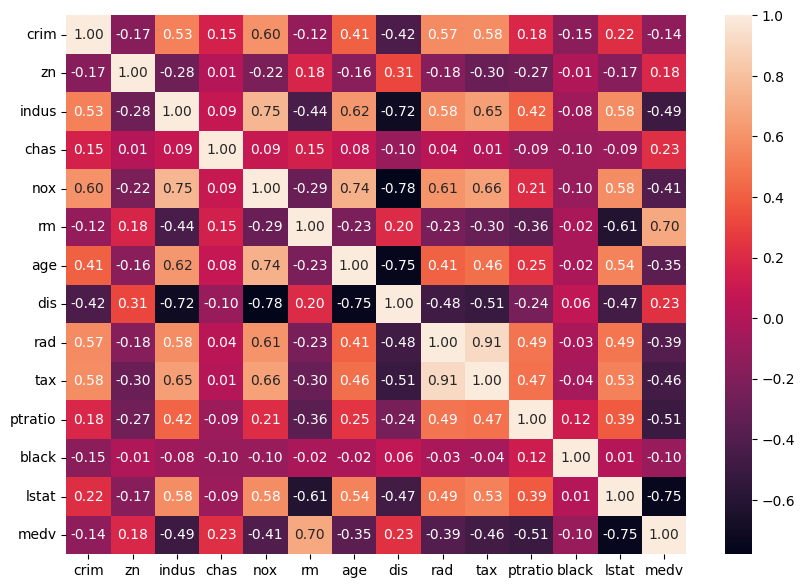

In [52]:
# heatmap correlation
dHouse_train = pd.concat([X_train, y_train], axis=1)
corr = dHouse_train.corr()

plt.figure(figsize=(10,7))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

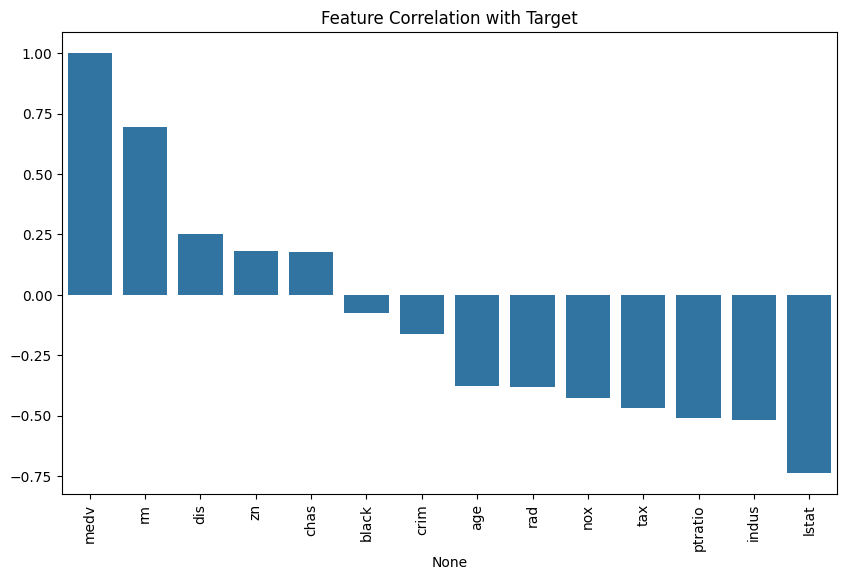

In [53]:
# Menghitung korelasi antar fitur dengan target
corr_matrix = d_house.corr()
target_corr = corr_matrix['medv'].sort_values(ascending=False)

# Plotting bar chart untuk korelasi fitur dengan target
plt.figure(figsize=(10, 6))
sns.barplot(x=target_corr.index, y=target_corr.values)
plt.title('Feature Correlation with Target')
plt.xticks(rotation=90)
plt.show()


In [54]:
# # drop redundant features
X_train = X_train.drop(columns=['rad'])
X_valid = X_valid.drop(columns=['rad'])
X_test = X_test.drop(columns=['rad'])

In [55]:
# Standarisasi data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [56]:
# calculate VIF scores
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

# Mengonversi X_train_scaled menjadi DataFrame
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X = add_constant(X_scaled_df)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df


,feature,vif_score
1,crim,2.001616
2,zn,1.215824
3,indus,3.522896
4,chas,1.088684
5,nox,5.046306
6,rm,1.862641
7,age,2.926867
8,dis,3.792900
9,tax,2.738609
10,ptratio,1.623934


## **Ridge**

In [57]:
# Ridge Regression dengan pencarian alpha terbaik
ridge = Ridge()
params = {'alpha': np.logspace(-6, 6, 13)}  # rentang alpha
ridge_search = GridSearchCV(ridge, param_grid=params, scoring='neg_mean_squared_error', cv=5)
ridge_search.fit(X_train_scaled, y_train)

# Menampilkan alpha terbaik
best_ridge_alpha = ridge_search.best_params_['alpha']
print(f'Best alpha for Ridge Regression: {best_ridge_alpha}')

# Membuat model Ridge dengan alpha terbaik
ridge_best = Ridge(alpha=best_ridge_alpha)
ridge_best.fit(X_train_scaled, y_train)


Best alpha for Ridge Regression: 10.0


Ridge(alpha=np.float64(10.0))

In [58]:
# Prediksi pada data train
y_train_pred_ridge = ridge_best.predict(X_train_scaled)

# Evaluasi dengan R-squared, MSE, dan MAE pada data train
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)*100
train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
train_mape_ridge = mean_absolute_percentage_error(y_train, y_train_pred_ridge)*100

# Tampilkan hasil evaluasi untuk Ridge
print(f"Ridge train R-squared: {train_r2_ridge}")
print(f"Ridge train Mean Absolute Error: {train_mae_ridge}")
print(f"Ridge train R Mean Squared Error: {train_mse_ridge}")
print(f"Ridge train Mean Absolute percentage Error: {train_mape_ridge}")

Ridge train R-squared: 73.6722131275378
Ridge train Mean Absolute Error: 3.483287910064474
Ridge train R Mean Squared Error: 23.491418907027715
Ridge train Mean Absolute percentage Error: 17.3689286444785


In [59]:
# Prediksi pada data validasi
y_valid_pred_ridge = ridge_best.predict(X_valid_scaled)

# Evaluasi dengan R-squared, MSE, dan MAE pada data validasi
valid_r2_ridge = r2_score(y_valid, y_valid_pred_ridge)*100
valid_mse_ridge = mean_squared_error(y_valid, y_valid_pred_ridge)
valid_mae_ridge = mean_absolute_error(y_valid, y_valid_pred_ridge)
valid_mape_ridge = mean_absolute_percentage_error(y_valid, y_valid_pred_ridge)*100

# Tampilkan hasil evaluasi untuk Ridge
print(f"Ridge Validation R-squared: {valid_r2_ridge}")
print(f"Ridge Validation Mean Absolute Error: {valid_mae_ridge}")
print(f"Ridge Validation R Mean Squared Error: {valid_mse_ridge}")
print(f"Ridge Validation Mean Absolute percentage Error: {valid_mape_ridge}")


Ridge Validation R-squared: 71.20459249353215
Ridge Validation Mean Absolute Error: 3.1936936147194106
Ridge Validation R Mean Squared Error: 18.93757736924678
Ridge Validation Mean Absolute percentage Error: 16.1954784914886


In [60]:
# Prediksi pada data test
y_test_pred_ridge = ridge_best.predict(X_test_scaled)

# Evaluasi dengan R-squared, MSE, dan MAE pada data test
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)*100
test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
test_mape_ridge = mean_absolute_percentage_error(y_test, y_test_pred_ridge)*100


# Tampilkan hasil evaluasi untuk Ridge
print(f"Ridge Test R-squared: {test_r2_ridge}")
print(f"Ridge Test Mean Squared Error: {test_mse_ridge}")
print(f"Ridge Test R Mean Absolute Error: {test_mae_ridge}")
print(f"Ridge Test Mean Absolute percentage Error: {test_mape_ridge}")


Ridge Test R-squared: 70.25134084202907
Ridge Test Mean Squared Error: 25.54508240574057
Ridge Test R Mean Absolute Error: 3.344055161943294
Ridge Test Mean Absolute percentage Error: 17.529057706291333


### **1. Performansi Model pada Data Training**  
- **R-squared (73.67%)**: Model mampu menjelaskan **73.67%** variabilitas data pada data training, menunjukkan kemampuan model yang baik dalam menangkap pola data latih.  
- **Mean Absolute Error (3.48)**: Rata-rata kesalahan prediksi model adalah **3.48 unit**, menunjukkan tingkat kesalahan prediksi yang cukup rendah.  
- **Root Mean Squared Error (23.49)**: RMSE menunjukkan adanya beberapa prediksi yang menyimpang lebih jauh dari nilai aktual, tetapi masih berada dalam rentang yang wajar.  
- **Mean Absolute Percentage Error (17.37%)**: Kesalahan rata-rata model sekitar **17.37%** terhadap nilai aktual, menunjukkan akurasi model yang cukup baik.

**Kesimpulan**: Performansi model di data training cukup baik, dengan tingkat error yang rendah dan R-squared yang tinggi, menunjukkan bahwa model mampu menangkap pola data latih secara efektif.  

---

### **2. Performansi Model pada Data Validation**  
- **R-squared (71.20%)**: Penurunan performa pada data validasi dibandingkan data training menunjukkan sedikit kehilangan kemampuan generalisasi, tetapi penurunan ini masih tergolong kecil.  
- **Mean Absolute Error (3.19)**: Rata-rata error pada data validasi lebih kecil dibandingkan data training, menunjukkan kemampuan model yang baik dalam melakukan prediksi pada data yang belum dilihat sebelumnya.  
- **Root Mean Squared Error (18.94)**: RMSE lebih rendah dibandingkan data training, menunjukkan model cukup stabil dan tidak terlalu terpengaruh oleh outlier.  
- **Mean Absolute Percentage Error (16.20%)**: Kesalahan rata-rata model pada data validasi lebih rendah daripada data training, dengan nilai **16.20%**, menunjukkan akurasi yang baik.

**Kesimpulan**: Performansi model pada data validasi sangat baik dan cukup stabil dibandingkan dengan data training. Hal ini menunjukkan model memiliki kemampuan generalisasi yang baik.  

---

### **3. Performansi Model pada Data Test**  
- **R-squared (70.25%)**: Performansi model pada data test sedikit lebih rendah dibandingkan data training dan validasi, tetapi tetap menunjukkan kemampuan generalisasi yang baik.  
- **Mean Absolute Error (3.34)**: Error pada data test sedikit lebih tinggi dibandingkan data validasi tetapi masih dalam rentang yang dapat diterima.  
- **Root Mean Squared Error (25.55)**: RMSE lebih tinggi dibandingkan data training dan validasi, menunjukkan adanya beberapa prediksi yang lebih jauh dari nilai aktual pada data test.  
- **Mean Absolute Percentage Error (17.53%)**: Error rata-rata model pada data test adalah **17.53%**, hanya sedikit lebih tinggi dari data training dan validasi.

**Kesimpulan**: Performansi model pada data test cukup baik dan konsisten, meskipun ada sedikit peningkatan error, yang bisa disebabkan oleh karakteristik data test yang berbeda atau kehadiran outlier.  

---

### **Kesimpulan Umum**
- **Overfitting:** Tidak ada tanda overfitting yang signifikan karena performa model pada data training, validasi, dan test cukup konsisten.  
- **Generalizability:** Model memiliki kemampuan generalisasi yang baik, seperti yang ditunjukkan oleh performa pada data validasi dan test.  
- **Stabilitas Model:** Model Ridge Regression menunjukkan stabilitas yang tinggi, dengan performa yang serupa di antara semua dataset (training, validasi, dan test).  



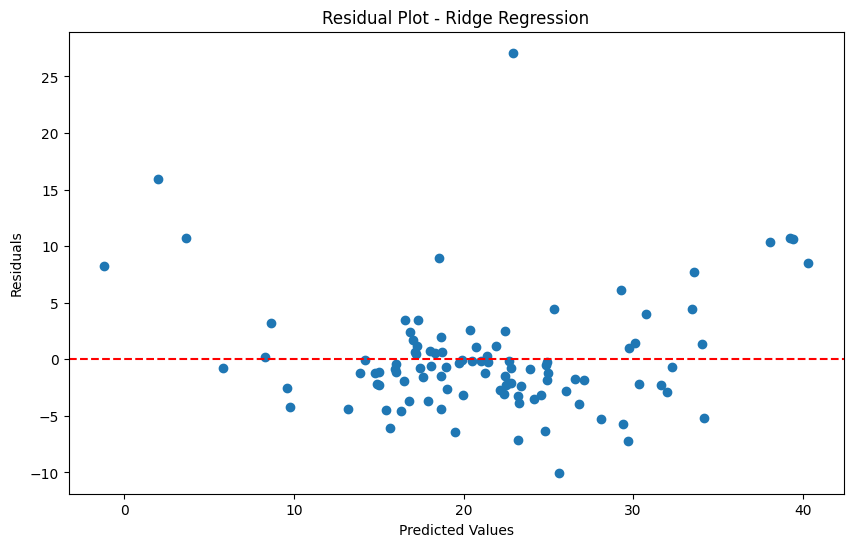

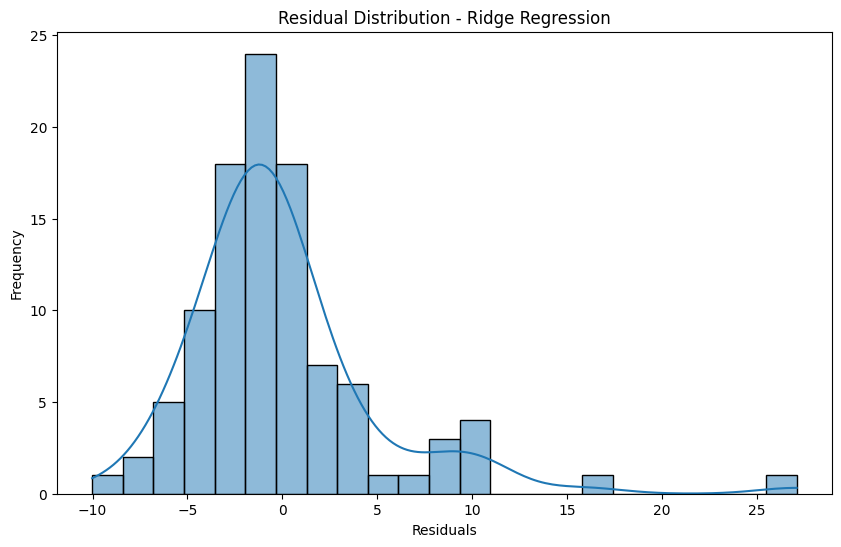

In [61]:
# Menghitung residual pada data test
residuals_ridge = y_test - y_test_pred_ridge

# Visualisasi residual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_ridge, residuals_ridge)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - Ridge Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Visualisasi distribusi residual
plt.figure(figsize=(10, 6))
sns.histplot(residuals_ridge, kde=True)
plt.title('Residual Distribution - Ridge Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


--------------------------------------
-------------------------------------

## **Lasso**

In [62]:
# Lasso Regression dengan pencarian alpha terbaik
lasso = Lasso()
lasso_search = GridSearchCV(lasso, param_grid=params, scoring='neg_mean_squared_error', cv=5)
lasso_search.fit(X_train_scaled, y_train)

# Menampilkan alpha terbaik
best_lasso_alpha = lasso_search.best_params_['alpha']
print(f'Best alpha for Lasso Regression: {best_lasso_alpha}')

# Membuat model Lasso dengan alpha terbaik
lasso_best = Lasso(alpha=best_lasso_alpha)
lasso_best.fit(X_train_scaled, y_train)


Best alpha for Lasso Regression: 1e-06


Lasso(alpha=np.float64(1e-06))

In [63]:
# Prediksi pada data train
y_train_pred_lasso = lasso_best.predict(X_train_scaled)

# Evaluasi dengan R-squared, MSE, dan MAE pada data train
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)*100
train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
train_mae_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
train_mape_lasso = mean_absolute_percentage_error(y_train, y_train_pred_lasso)*100

# Tampilkan hasil evaluasi untuk lasso
print(f"Lasso train R-squared: {train_r2_lasso}")
print(f"Lasso train Mean Absolute Error: {train_mae_lasso}")
print(f"Lasso train R Mean Squared Error: {train_mse_lasso}")
print(f"Lasso train Mean Absolute percentage Error: {train_mape_lasso}")

Lasso train R-squared: 73.75661615490003
Lasso train Mean Absolute Error: 3.5022043280290456
Lasso train R Mean Squared Error: 23.41610885979919
Lasso train Mean Absolute percentage Error: 17.498545323105148


In [64]:
# Prediksi pada data validasi
y_valid_pred_lasso = lasso_best.predict(X_valid_scaled)

# Evaluasi dengan R-squared, MSE, dan MAE pada data validasi
valid_r2_lasso = r2_score(y_valid, y_valid_pred_lasso)*100
valid_mse_lasso = mean_squared_error(y_valid, y_valid_pred_lasso)
valid_mae_lasso = mean_absolute_error(y_valid, y_valid_pred_lasso)
valid_mape_lasso = mean_absolute_percentage_error(y_valid, y_valid_pred_lasso)*100

# Tampilkan hasil evaluasi untuk Lasso
print(f"Lasso Validation R-squared: {valid_r2_lasso}")
print(f"Lasso Validation Mean Absolute Error: {valid_mae_lasso}")
print(f"Lasso Validation R Mean Squared Error: {valid_mse_lasso}")
print(f"Lasso Validation Mean Absolute percentage Error: {valid_mape_lasso}")


Lasso Validation R-squared: 71.15227837924871
Lasso Validation Mean Absolute Error: 3.227874387761078
Lasso Validation R Mean Squared Error: 18.97198225087673
Lasso Validation Mean Absolute percentage Error: 16.379680958480606


In [65]:
# Prediksi pada data test
y_test_pred_lasso = lasso_best.predict(X_test_scaled)

# Evaluasi dengan R-squared, MSE, dan MAE pada data test
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)*100
test_mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
test_mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
test_mape_lasso = mean_absolute_percentage_error(y_test, y_test_pred_lasso)*100

# Tampilkan hasil evaluasi untuk Lasso
print(f"Lasso Test R-squared: {test_r2_lasso}")
print(f"Lasso Test Mean Squared Error: {test_mse_lasso}")
print(f"Lasso Test Mean Absolute Error: {test_mae_lasso}")
print(f"Lasso Test Mean Absolute percentage Error: {test_mape_lasso}")


Lasso Test R-squared: 70.30036766824519
Lasso Test Mean Squared Error: 25.502983220391332
Lasso Test Mean Absolute Error: 3.3725188754189515
Lasso Test Mean Absolute percentage Error: 17.62697428449812


In [66]:
# Simpan model dan scaler
joblib.dump(lasso_best, 'lasso_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

### **1. Performansi Model pada Data Training**  
- **R-squared (73.76%)**: Model mampu menjelaskan **73.76%** variabilitas data pada data training, menunjukkan performa yang sangat baik dalam menangkap pola data latih.  
- **Mean Absolute Error (3.50)**: Rata-rata kesalahan prediksi model adalah **3.50 unit**, yang masih dalam rentang kesalahan rendah.  
- **Root Mean Squared Error (23.42)**: RMSE menunjukkan adanya beberapa prediksi yang menyimpang lebih jauh dari nilai aktual, namun masih dapat diterima.  
- **Mean Absolute Percentage Error (17.50%)**: Model memiliki rata-rata kesalahan persentase **17.50%** terhadap nilai aktual, mengindikasikan tingkat akurasi yang memadai.  

**Kesimpulan**: Performansi model pada data training sangat baik, dengan tingkat error rendah dan kemampuan menjelaskan variabilitas yang tinggi.  

---

### **2. Performansi Model pada Data Validation**  
- **R-squared (71.15%)**: Performansi pada data validasi sedikit menurun dibandingkan data training, namun penurunan ini tergolong kecil dan wajar.  
- **Mean Absolute Error (3.23)**: Rata-rata error pada data validasi lebih rendah dibandingkan pada data training, menunjukkan stabilitas prediksi yang baik.  
- **Root Mean Squared Error (18.97)**: RMSE lebih kecil dibandingkan data training, menunjukkan bahwa model memiliki prediksi yang lebih baik pada data validasi.  
- **Mean Absolute Percentage Error (16.38%)**: Model memiliki rata-rata kesalahan persentase **16.38%** pada data validasi, sedikit lebih rendah dari data training, menunjukkan generalisasi yang baik.  

**Kesimpulan**: Performansi pada data validasi cukup baik dan menunjukkan model tidak mengalami overfitting.  

---

### **3. Performansi Model pada Data Test**  
- **R-squared (70.30%)**: Performansi pada data test sedikit lebih rendah dibandingkan data training dan validasi, namun tetap menunjukkan kemampuan generalisasi yang baik.  
- **Mean Absolute Error (3.37)**: Kesalahan rata-rata pada data test sedikit lebih tinggi dibandingkan pada data validasi, tetapi masih dalam rentang yang dapat diterima.  
- **Root Mean Squared Error (25.50)**: RMSE menunjukkan adanya beberapa prediksi yang lebih jauh dari nilai aktual pada data test, yang wajar untuk data baru.  
- **Mean Absolute Percentage Error (17.63%)**: Model memiliki rata-rata kesalahan persentase **17.63%** pada data test, menunjukkan stabilitas yang baik dibandingkan data training dan validasi.  

**Kesimpulan**: Performansi model pada data test cukup baik dan menunjukkan kemampuan generalisasi yang memadai meskipun ada sedikit peningkatan error.  

---

### **Kesimpulan Umum**
- **Overfitting**: Tidak ada tanda overfitting yang signifikan, karena performa model pada data training, validasi, dan test cukup konsisten.  
- **Generalizability**: Model Lasso menunjukkan kemampuan generalisasi yang baik, dengan penurunan performa yang minimal pada data validasi dan test.  
- **Stabilitas**: Model stabil pada semua dataset, dengan tingkat kesalahan yang tidak terlalu berbeda antar dataset.  

**Rekomendasi**: Model Lasso cocok digunakan karena menunjukkan performa yang baik dan stabil di semua dataset.

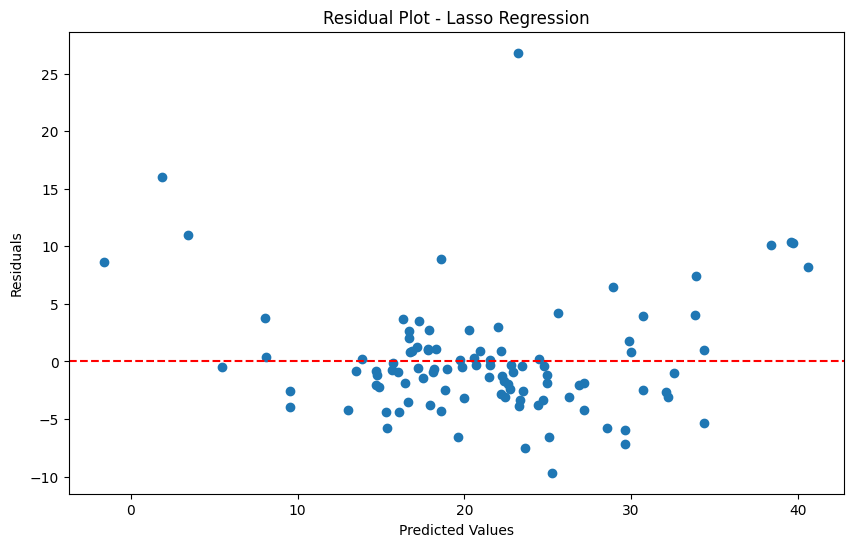

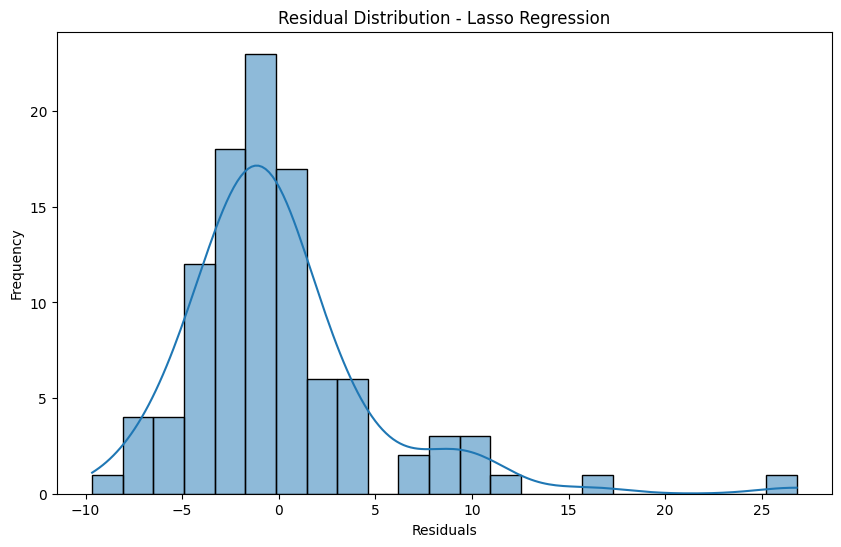

In [67]:
# Menghitung residual pada data test
residuals_lasso = y_test - y_test_pred_lasso

# Visualisasi residual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_lasso, residuals_lasso)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot - Lasso Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Visualisasi distribusi residual
plt.figure(figsize=(10, 6))
sns.histplot(residuals_lasso, kde=True)
plt.title('Residual Distribution - Lasso Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


Berikut asumsi yang dapat diambil berdasarkan  residual plot:

### Asumsi:
1. **Linear Relationship: OK**  
   Titik-titik residual tersebar cukup acak di sekitar garis horizontal merah (y=0). Ini menunjukkan bahwa hubungan antara fitur dan target cukup linear.

2. **Variance Stable (Homoscedasticity): NO**  
   Penyebaran residual tidak konsisten. Variasinya tampak lebih lebar di bagian kiri (untuk nilai prediksi kecil) dan mengecil di bagian tengah, lalu melebar lagi di bagian kanan (untuk nilai prediksi besar). Ini menunjukkan adanya masalah heteroskedastisitas, di mana variansi residual tidak stabil.

3. **Independent Residual: OK**  
   Tidak ada pola tertentu yang mencolok di antara residual, seperti garis lengkung atau pola berulang. Ini menunjukkan bahwa residual cukup independen satu sama lain.

### Kesimpulan:  
Model memiliki hubungan linear yang baik, namun perlu memperbaiki heteroskedastisitas, misalnya dengan mencoba transformasi data (log, sqrt, dll.) atau menggunakan model yang lebih robust terhadap variansi yang tidak stabil.